# How to run jobs in Raycluster using Jupyterhub?


In [ ]:
!pip install -q ray[default] huggingface_hub

# We can get this address from the workder node of the RayCluster
%env RAY_ADDRESS=gpu-raycluster-head-svc.ray-gpu.svc.cluster.local:6379

# Check Cluster Resources

The result should be consistent with what we see in the Ray dashboard, under the "overview" tab:

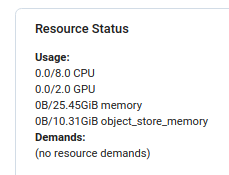

In [ ]:
! ray job submit -- python -c "import ray; ray.init(); print(ray.cluster_resources())"

## (Only when necessary) Use `ray job stop` to stop a running job

We have to first "Interrupt the kernel" with the square button in the menlar.

In [ ]:
!ray job stop raysubmit_qEBJ46FmkFFWaNAY

# Step 1: Prepare Data

In [ ]:
# Define some environment variables that are used by all

%env ORIG_MODEL_NAME=stabilityai/stable-diffusion-2-1
%env ORIG_MODEL_HASH=5cae40e6a2745ae2b01ad92ae5043f95f23644d6
%env CLASS_NAME=dog

## 1.0 Preprare Folders

We should see a `data` folder created under current folder.

In [ ]:
%%bash

export DATA_PREFIX="$HOME/efs/src/jark-demo/05_dreambooth_finetuning/data" # EFS is mounted on $HOME/efs
export ORIG_MODEL_DIR="$DATA_PREFIX/model-orig"
export ORIG_MODEL_PATH="$ORIG_MODEL_DIR/models--${ORIG_MODEL_NAME/\//--}/snapshots/$ORIG_MODEL_HASH"
export TUNED_MODEL_DIR="$DATA_PREFIX/model-tuned"
export IMAGES_REG_DIR="$DATA_PREFIX/images-reg"
export IMAGES_OWN_DIR="$DATA_PREFIX/images-own"
export IMAGES_NEW_DIR="$DATA_PREFIX/images-new"

mkdir -p $ORIG_MODEL_DIR $TUNED_MODEL_DIR $IMAGES_REG_DIR $IMAGES_OWN_DIR $IMAGES_NEW_DIR

echo "ORIG_MODEL_DIR=$ORIG_MODEL_DIR"
echo "IMAGES_OWN_DIR=$IMAGES_OWN_DIR"
echo "ORIG_MODEL_PATH=$ORIG_MODEL_PATH"
echo "IMAGES_REG_DIR=$IMAGES_REG_DIR"

## 1.1 Download the Pre-trained Stable Diffusino Model

In [ ]:
%env ORIG_MODEL_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig

import os
from huggingface_hub import snapshot_download

snapshot_download(
        repo_id=os.environ.get('ORIG_MODEL_NAME'),
        revision=os.environ.get('ORIG_MODEL_HASH'), 
        cache_dir=os.environ.get('ORIG_MODEL_DIR')
    )

## 1.2 Download the Input Subjet Data

In this case, we choose the [diffusers/dog-example](https://huggingface.co/datasets/diffusers/dog-example), which contains 5 photos of a particular dog that we'll call "[v] dog".

In [ ]:
%env IMAGES_OWN_DIR=/home/jovyan/efs/src/jark-demo/05_dreambooth_finetuning/data/images-own

from huggingface_hub import snapshot_download
import os
import sys

local_dir = os.environ.get('IMAGES_OWN_DIR')

os.makedirs(local_dir, exist_ok=True)

snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir,
    repo_type="dataset",
    ignore_patterns=".gitattributes",
)


## 1.3 Run Stable Diffusion Inference: on Ray Cluster

Note that we need to set envrionment variables ORIG_MODEL_PATH and IMAGES_REG_DIR based on the location on the Ray cluster instead of the Jupyter notebook. The user is `ray` instead of `jovyan`.

In [ ]:
%env PROJECT_ROOT=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning
%env ORIG_MODEL_PATH=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/model-orig/models--stabilityai--stable-diffusion-2-1/snapshots/5cae40e6a2745ae2b01ad92ae5043f95f23644d6
%env IMAGES_REG_DIR=/home/ray/efs/src/jark-demo/05_dreambooth_finetuning/data/images-reg

!ray job submit -- python  ${PROJECT_ROOT}/dreambooth/generate.py \
--model_dir=$ORIG_MODEL_PATH \
--output_dir=$IMAGES_REG_DIR \
--prompts="photo of a $CLASS_NAME" \
--num_samples_per_prompt=200 \
--use_ray_data

# Step 2: DreamBooth Training on GPUs

In [ ]:
pwd

In [ ]:
!./step2_training.sh

In [ ]:
!ray job stop raysubmit_qN7q59HQDR2R2DEd

# Step 3: Interference


In [ ]:
! ./step3_inference.sh

### Example output image

In [ ]:
from IPython.display import Image
Image("/data/tmp/artifacts/example_out.jpg")